In [1]:
# !{sys.executable} -m pip install statsmodels

In [1]:
import symengine
import cobra
from cobra.io import load_json_model
# from cobra.io.sbml import create_cobra_model_from_sbml_file
from cobra.core import Reaction
from cobra.util.util import format_long_string
from optlang.symbolics import Zero
import libsbml

from copy import deepcopy
import pickle
import pandas
import pandas as pd
import glob
import json
import random
import statistics
from statistics import mean
import time
import numpy as np
import sys
import operator
import datetime
from collections import Counter

import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
import seaborn as sns; sns.set()
from IPython.display import clear_output
from matplotlib_venn import venn3

from functions.canyun_functions import *
from functions.carveme_data_functions import *

In [2]:
%config InlineBackend.figure_format = 'svg'
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")
colors = sns.color_palette("colorblind", 10)
muted = sns.color_palette("muted", 10)

# Biolog Growth Data

In [3]:
# Biolog Data
def read_o2_biolog_data(sheet_names):
    biolog_o2 = dict()
    for sheet_name in sheet_names:
        df = pandas.read_excel("Biolog_O2_PM1_PM2A_All.xlsx", sheet_name)
        biolog_o2[sheet_name] = df.set_index('Cycle Nr.').transpose()
    return biolog_o2
    
def read_ano2_biolog_data(sheet_names):
    biolog_ano2 = pandas.DataFrame()
    for sheet_name in sheet_names:
        temp_df = pandas.read_excel("Biolog_ANO2_PM1_PM2A_All.xlsx", sheet_name)
        temp_list = []
        for rowi in [0,1,2,3,4,5,6,7]:
            for coli in [1,2,3,4,5,6,7,8,9,10,11,12]:
                temp_list.append(float(temp_df.iloc[rowi,coli]))
        biolog_ano2[sheet_name] = temp_list
    
    well_ids = []
    for letter in ['A','B','C','D','E','F','G','H']:
        for num in ['1','2','3','4','5','6','7','8','9','10','11','12']:
            well_ids.append(letter+num)
    biolog_ano2['Well_ids'] = well_ids
    return biolog_ano2

def process_ano2_data(ano2, sheet_names, cutoff):
    ano2['C_avg'] = ano2[sheet_names[9:]].mean(axis=1)
#     group_list_data = []
    for sheet_name in sheet_names[0:9]:
        ano2[sheet_name] = ano2[sheet_name] - ano2['C_avg']
#         group_list_data.append(sheet_name.split('.')[0])
    ano2 = ano2.drop(columns=sheet_names[9:]+['C_avg'])
    ano2 = ano2.set_index('Well_ids').transpose()
#     ano2['Groups'] = group_list_data
    
    %config InlineBackend.figure_format = 'svg'
    sns.distplot(ano2.mean(axis=0), bins=30, kde=False)
    nc_x = ano2['A1'].mean(axis=0)
    plt.axvline(nc_x, 0, 1)
    plt.axvline(cutoff, 0, 1)
    
    ano2.loc['mean'] = ano2.mean()
    
    ano2.loc['growth'] = (ano2.loc['mean'] >= cutoff)
    
    return ano2

def process_o2_data(sheet_names, PM_dict, cutoff):
    output_df = pandas.DataFrame()
    well_ids = []
    for letter in ['A','B','C','D','E','F','G','H']:
        for num in ['1','2','3','4','5','6','7','8','9','10','11','12']:
            well_ids.append(letter+num)
    output_df['Well_ids'] = well_ids

    for sheet_name in sheet_names[0:3]:
        working_df = PM_dict[sheet_name]
        for well_id in well_ids:
            control_df = PM_dict[sheet_names[3]]
            working_df[well_id] = working_df[well_id] - control_df[well_id]
            working_df[well_id] = working_df[well_id] - working_df.loc[1,well_id]
#             working_df[well_id] = working_df[well_id] - working_df['A1']
        working_df.drop(working_df.loc[working_df['Time [s]'] > (48.01*3600)].index, inplace=True)
        PM_dict[sheet_name] = working_df
        
        temp_auc_list = []
        for well_id in well_ids:
#             temp_auc_list.append(np.trapz(working_df[well_id], x=working_df['Time [s]']))
            temp_auc_list.append(working_df[well_id].iloc[-1])
        output_df[sheet_name] = temp_auc_list
    output_df['mean'] = output_df[sheet_names[0:3]].mean(axis=1)
    output_df['growth'] = (output_df['mean'] >= cutoff)
    output_df = output_df.set_index('Well_ids')
    
    %config InlineBackend.figure_format = 'svg'
    sns.distplot(output_df['mean'], bins=30, kde=False)
    nc_x = output_df.loc['A1','mean']
    plt.axvline(nc_x, 0, 1)
    plt.axvline(cutoff, 0, 1)

    return output_df, PM_dict

def plot_growth_curves(proc_dict, auc_o2, sheet_names_o2, ylimit, ano2_p, plate_id):
    letters = ['A','B','C','D','E','F','G','H']
    nums = ['1','2','3','4','5','6','7','8','9','10','11','12']

    %config InlineBackend.figure_format = 'svg'
    fig, axs = plt.subplots(8, 12, figsize = (50, 35))

    for sheet_name in sheet_names_o2:
        temp_df = proc_dict[sheet_name]
        for row in [0,1,2,3,4,5,6,7]:
            for col in [0,1,2,3,4,5,6,7,8,9,10,11]:
                if auc_o2.loc[letters[row]+nums[col],'growth']:
                    axs[row, col].plot(temp_df['Time [s]'].divide(3600), temp_df[letters[row]+nums[col]], color='green')
                else:
                    axs[row, col].plot(temp_df['Time [s]'].divide(3600), temp_df[letters[row]+nums[col]], color='black')
                axs[row, col].set_title(plate_id+' '+letters[row]+nums[col])
                axs[row, col].set_ylim(ylimit)

    for row in [0,1,2,3,4,5,6,7]:
        for col in [0,1,2,3,4,5,6,7,8,9,10,11]:
            if auc_o2.loc[letters[row]+nums[col],'growth']:
                axs[row, col].text(0, ylimit[1]-0.1, 'Aerobic Growth', fontsize=12, color='green')
            else:
                axs[row, col].text(0, ylimit[1]-0.1, 'No Aerobic Growth', fontsize=12, color='black')
            
            temp_y = ano2_p.reset_index().loc[0:8,letters[row]+nums[col]]

            if ano2_p.loc['growth',letters[row]+nums[col]] == 1.0:
                axs[row, col].scatter(x=[40]*9, y=temp_y, color='green')
                axs[row, col].text(0, ylimit[1]-0.2, 'Anaerobic Growth', fontsize=12, color='green')
            else:
                axs[row, col].scatter(x=[40]*9, y=temp_y, color='black')
                axs[row, col].text(0, ylimit[1]-0.2, 'No Anaerobic Growth', fontsize=12, color='black')
    fig.savefig(plate_id + '_growth_curves.svg')
    return

/home/tjmoutinho/CanyonGENREs-testing/canyuns/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


70


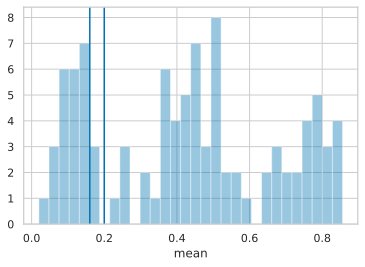

In [4]:
sheet_names_PM1_o2 = ['PM1_1','PM1_2','PM1_3','PM1_C']
PM1_o2 = read_o2_biolog_data(sheet_names_PM1_o2)
PM1_auc_o2, PM1_o2_proc = process_o2_data(sheet_names_PM1_o2, PM1_o2, 0.2)
print(PM1_auc_o2['growth'].sum())

34.0


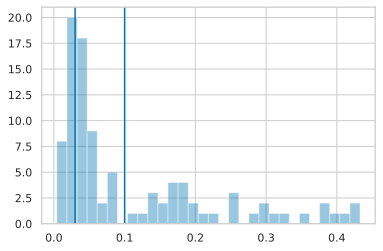

In [5]:
sheet_names_PM1_ano2 = ['PM1_1.1','PM1_1.2','PM1_1.3',
                        'PM1_2.1','PM1_2.2','PM1_2.3',
                        'PM1_3.1','PM1_3.2','PM1_3.3',
                        'PM1_C.1','PM1_C.2','PM1_C.3']
PM1_ano2 = read_ano2_biolog_data(sheet_names_PM1_ano2)
PM1_ano2_p = process_ano2_data(PM1_ano2, sheet_names_PM1_ano2, 0.1)
print(PM1_ano2_p.loc['growth'].sum())

In [6]:
plot_growth_curves(PM1_o2_proc, PM1_auc_o2, ['PM1_1','PM1_2','PM1_3'], [-0.05, 1.1], PM1_ano2_p, 'PM1')

22


/home/tjmoutinho/CanyonGENREs-testing/canyuns/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


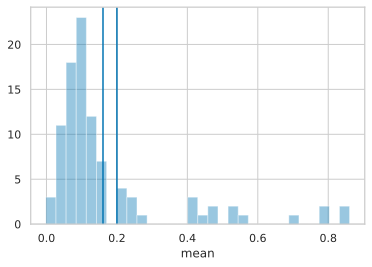

In [7]:
sheet_names_PM2A_o2 = ['PM2A_1','PM2A_2','PM2A_3','PM2A_C']
PM2A_o2 = read_o2_biolog_data(sheet_names_PM2A_o2)

PM2A_auc_o2, PM2A_o2_proc = process_o2_data(sheet_names_PM2A_o2, PM2A_o2, 0.2)
print(PM2A_auc_o2['growth'].sum())

9.0


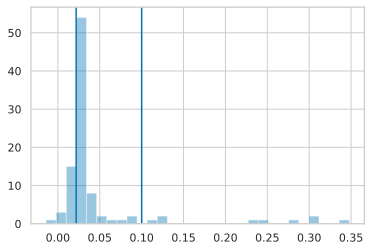

In [8]:
sheet_names_PM2A_ano2 = ['PM2A_1.1','PM2A_1.2','PM2A_1.3',
                         'PM2A_2.1','PM2A_2.2','PM2A_2.3',
                         'PM2A_3.1','PM2A_3.2','PM2A_3.3',
                         'PM2A_C.1','PM2A_C.2','PM2A_C.3']
PM2A_ano2 = read_ano2_biolog_data(sheet_names_PM2A_ano2)
PM2A_ano2_p = process_ano2_data(PM2A_ano2, sheet_names_PM2A_ano2, 0.1)
print(PM2A_ano2_p.loc['growth'].sum())

In [9]:
plot_growth_curves(PM2A_o2_proc, PM2A_auc_o2, ['PM2A_1','PM2A_2','PM2A_3'], [-0.05, 1.1], PM2A_ano2_p, 'PM2A')

# Diamond Alignment Data

In [10]:
columns = ['query_gene', 'BiGG_ref_gene', 'pident', 'length', 'mismatch', 'gapopen',
           'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

filename = 'EcN.align'
anno_data = pd.read_csv(filename, sep='\t', names=columns)

anno_data = anno_data[['query_gene', 'BiGG_ref_gene', 'bitscore']]

len(anno_data)

91408

/home/tjmoutinho/CanyonGENREs-testing/canyuns/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bitscore'>

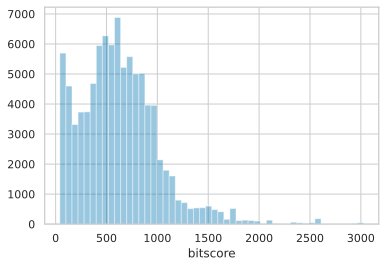

In [11]:
sns.distplot(anno_data['bitscore'], kde=False, hist=True, label="bit scores")

In [12]:
gpr_data = pd.read_csv('bigg_gprs.csv')

In [13]:
annotation = anno_data
gprs = gpr_data

# filter best match for each gene
gene2gene = annotation.sort_values(by='bitscore', ascending=False) \
                      .groupby('BiGG_ref_gene', as_index=False).apply(lambda x: x.iloc[0])

In [14]:
gene2gene.head(10)

query_gene      BiGG_ref_gene  bitscore
0    fig|316435.51.peg.9  e_coli_core.b0008     619.0
1  fig|316435.51.peg.126  e_coli_core.b0114    1799.6
2  fig|316435.51.peg.128  e_coli_core.b0115     771.5
3  fig|316435.51.peg.129  e_coli_core.b0116     939.5
4  fig|316435.51.peg.131  e_coli_core.b0118    1727.6
5  fig|316435.51.peg.451  e_coli_core.b0356     743.0
6  fig|316435.51.peg.555  e_coli_core.b0451     807.7
7  fig|316435.51.peg.577  e_coli_core.b0474     421.4
8  fig|316435.51.peg.588  e_coli_core.b0485     607.4
9  fig|316435.51.peg.771  e_coli_core.b0720     870.2

In [15]:
# merge with gpr table
gprs['BiGG_ref_gene'] = gprs.apply(lambda row: '{}.{}'.format(row['model'], row['gene'][2:]), axis=1)
gene_scores = pd.merge(gene2gene, gprs, how='right')

In [16]:
gene_scores.head(10)

query_gene                  BiGG_ref_gene  bitscore  \
0        NaN  iRC1080.CRv4_Au5_s3_g10685_t1       NaN   
1        NaN  iRC1080.CRv4_Au5_s3_g10685_t1       NaN   
2        NaN  iRC1080.CRv4_Au5_s3_g10685_t1       NaN   
3        NaN  iRC1080.CRv4_Au5_s5_g12128_t1       NaN   
4        NaN               STM_v1_0.STM2040       NaN   
5        NaN               STM_v1_0.STM2040       NaN   
6        NaN               STM_v1_0.STM2041       NaN   
7        NaN               STM_v1_0.STM2041       NaN   
8        NaN               STM_v1_0.STM2042       NaN   
9        NaN               STM_v1_0.STM2042       NaN   

                      gene                                    protein  \
0  G_CRv4_Au5_s3_g10685_t1                    P_CRv4_Au5_s3_g10685_t1   
1  G_CRv4_Au5_s3_g10685_t1                    P_CRv4_Au5_s3_g10685_t1   
2  G_CRv4_Au5_s3_g10685_t1                    P_CRv4_Au5_s3_g10685_t1   
3  G_CRv4_Au5_s5_g12128_t1                    P_CRv4_Au5_s5_g12128_t1   
4                G_STM2040  P_STM2040:STM2041:STM2042:STM2043:STM2044   
5                G_STM2040  P_STM2040:STM2041:STM2042:STM2043:STM2044   
6                G_STM2041  P_STM2040:STM2041:STM2042:STM2043:STM2044   
7                G_STM2041  P_STM2040:STM2041:STM2042:STM2043:STM2044   
8                G_STM2042  P_STM2040:STM2041:STM2042:STM2043:STM2044   
9                G_STM2042  P_STM2040:STM2041:STM2042:STM2043:STM2044   

         reaction     model  
0   R_10FTHFGLULL   iRC1080  
1          R_DHFS   iRC1080  
2     R_THFGLUS_1   iRC1080  
3  R_10FTHFGLULLm   iRC1080  
4      R_12PPDRDH  STM_v1_0  
5          R_PPDD  STM_v1_0  
6      R_12PPDRDH  STM_v1_0  
7          R_PPDD  STM_v1_0  
8      R_12PPDRDH  STM_v1_0  
9          R_PPDD  STM_v1_0

In [17]:
spontaneous_score = 1.0
# add default scores for spontaneous genes
spontaneous = {'G_s0001', 'G_S0001', 'G_s_0001', 'G_S_0001', 'G_KPN_SPONT'}
gene_scores.loc[gene_scores.gene.isin(spontaneous), 'bitscore'] = spontaneous_score
gene_scores.loc[gene_scores.gene.isin(spontaneous), 'query_gene'] = 'spontaneous'

In [18]:
# from gene to protein scores
protein_scores = gene_scores.groupby(['protein', 'reaction', 'model'], as_index=False) \
    .agg({'query_gene': merge_subunits, 'bitscore': merge_subunit_scores})

protein_scores.rename(columns={'query_gene': 'GPR'}, inplace=True)

In [19]:
protein_scores.head(10)

protein     reaction  \
0                                              P_100        R_ADA   
1                                              P_100       R_ADAe   
2                                              P_100       R_DADA   
3                                        P_100041375    R_P4503A4   
4  P_100042918:17711:22272:22273:66152:66445:6659...  R_CYOR_u10m   
5                                        P_100043349       R_GAPD   
6                                        P_100043684      R_AMY1e   
7                                        P_100043684      R_AMY2e   
8                                        P_10005_AT1      R_PTE2x   
9                                        P_10005_AT2      R_PTE2x   

         model   GPR  bitscore  
0  iAT_PLT_636  None       0.0  
1  iAT_PLT_636  None       0.0  
2  iAT_PLT_636  None       0.0  
3      iMM1415  None       0.0  
4      iMM1415  None       0.0  
5      iMM1415  None       0.0  
6      iMM1415  None       0.0  
7      iMM1415  None       0.0  
8       RECON1  None       0.0  
9       RECON1  None       0.0

In [20]:
# from protein to reaction scores
reaction_scores = protein_scores.groupby(['reaction'], as_index=False) \
    .agg({'GPR': merge_proteins, 'bitscore': merge_protein_scores}).dropna()

avg_score = reaction_scores['bitscore'].median()
avg_score

700.7

In [21]:
reaction_scores.head(10)

reaction                                                GPR  \
3       R_12PPDRtex  (fig|316435.51.peg.1359 or fig|316435.51.peg.1...   
5       R_12PPDStex  (fig|316435.51.peg.1359 or fig|316435.51.peg.1...   
12         R_13PPDH                              fig|316435.51.peg.736   
13  R_14GLUCANabcpp  ((fig|316435.51.peg.1956 and fig|316435.51.peg...   
14   R_14GLUCANtexi                             fig|316435.51.peg.4621   
29        R_1PPDCRc                              fig|316435.51.peg.849   
30      R_23CAMPtex  (fig|316435.51.peg.1359 or fig|316435.51.peg.1...   
32      R_23CCMPtex  (fig|316435.51.peg.1359 or fig|316435.51.peg.1...   
33      R_23CGMPtex  (fig|316435.51.peg.1359 or fig|316435.51.peg.1...   
38      R_23CUMPtex  (fig|316435.51.peg.1359 or fig|316435.51.peg.1...   

    bitscore  
3     765.00  
5     765.00  
12    153.70  
13    779.15  
14    923.30  
29    149.10  
30    765.00  
32    765.00  
33    765.00  
38    765.00

In [22]:
reaction_scores['normalized_score'] = reaction_scores['bitscore'] / avg_score

In [23]:
len(reaction_scores)

3017

/home/tjmoutinho/CanyonGENREs-testing/canyuns/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bitscore'>

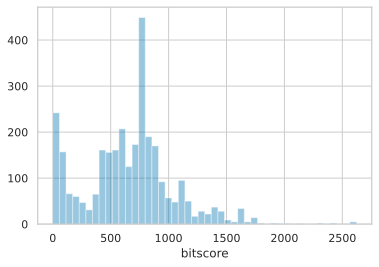

In [24]:
sns.distplot(reaction_scores['bitscore'], kde=False, hist=True, label="Rxn bit scores")

In [25]:
# pickle.dump(reaction_scores, open('EcN_rxn_scores.pickle','wb'))

# CANYUNs Model Building

In [26]:
# Calculate Model accuracy
def calc_acc(output):
    growth_tp = 0
    growth_fp = 0
    growth_tn = 0
    growth_fn = 0
    growth_INFg = 0
    growth_INFng = 0

    for key in output[0]:
        if gng_dict_long[key] > 0:
            growth_tp+=1
        elif gng_dict_long[key] == 0:
            growth_fp+=1
    for key in output[1]:
        if gng_dict_long[key] > 0:
            growth_fn+=1
        elif gng_dict_long[key] == 0:
            growth_tn+=1
    for key in output[2]:
        if gng_dict_long[key] > 0:
            growth_INFg+=1
        elif gng_dict_long[key] == 0:
            growth_INFng+=1 
    acc = (growth_tp+growth_tn+growth_INFng)/(growth_tp+growth_tn+growth_INFng+growth_fp+growth_fn+growth_INFg)
    print('Accuracy:', (growth_tp+growth_tn+growth_INFng)/(growth_tp+growth_tn+growth_INFng+growth_fp+growth_fn+growth_INFg))
    print('True Pos', growth_tp)
    print('False Pos', growth_fp)
    print('True Neg', growth_tn)
    print('False Neg', growth_fn)
    print('-------------------')

    return(acc)

In [27]:
# Load Biolog Well ID to BIGG metabolite ID conversion table
df_conversion = pd.read_csv("bigg-modelSEED-biolog-conversion.csv",index_col = 0)
conv_dict = {}
for index, row in df_conversion.iterrows():
    string = str(row['BIGG_id'])#.replace('\xa0', '')
    carbon_sources = string.split(', ')
    try:
        if carbon_sources[0] != 'nan':
            carbon_sources[0] = carbon_sources[0] + '_e'
    except:
        pass
    try:
        carbon_sources[1] = carbon_sources[1] + '_e'
    except:
        pass
    if index.startswith('PM1') or index.startswith('PM2A'):
        conv_dict[index] = carbon_sources
print('Number of well IDs:', len(list(conv_dict.values())))

Number of well IDs: 192


In [28]:
# Load curated universal model
from cobra.core import *
universal = pickle.load(open('bigg_universal_moutinho_2.pickle','rb'))
universal.groups = DictList()
universal

<Model bigg_universe at 0x7fd367e50b38>

In [29]:
BM_rxn = universal.reactions.get_by_id('Biomass')
BM_rxn.lower_bound = 0.0
BM_rxn.upper_bound = 1000.0
fba_expr = BM_rxn.forward_variable + BM_rxn.reverse_variable
universal.objective = universal.problem.Objective(fba_expr, direction='max', sloppy=True)
universal.solver.update()
universal

<Model bigg_universe at 0x7fd367e50b38>

In [30]:
# Check for all extracellular metabolites
missing_e_mets = []
missing_c_mets = []
missing_e_met_keys = []
missing_c_met_keys = []
for key, mets in conv_dict.items():
    for met_id in mets:
        if met_id != 'nan':
            try:
                universal.metabolites.get_by_id(met_id)
            except:
                missing_e_mets.append(met_id)
                missing_e_met_keys.append(key)
                try:
                    met_id_c = met_id[:-1] + 'c'
                    universal.metabolites.get_by_id(met_id_c)
                except:
                    missing_c_mets.append(met_id_c)
                    missing_c_met_keys.append(key)
print(len(missing_e_mets))
print(len(missing_c_mets))

34
28


In [31]:
nan_wells =[]
for key, mets in conv_dict.items():
    for met in mets:
        if met == 'nan':
            nan_wells.append(key)
useless_wells = nan_wells + missing_e_met_keys # + duplicate_wells
print('Number of Biolog wells that we cannot simulate with:', len(set(useless_wells)))

Number of Biolog wells that we cannot simulate with: 81


In [32]:
well_ids = []
for letter in ['A','B','C','D','E','F','G','H']:
    for num in ['1','2','3','4','5','6','7','8','9','10','11','12']:
        well_ids.append(letter+num)

gng_dict_long = dict()
for well_id in well_ids:
    if PM1_auc_o2.loc[well_id,'growth']: # PM1 Aerobic Growth
        gng_dict_long['PM1'+well_id+'_1'] = 1.0
    else:
        gng_dict_long['PM1'+well_id+'_1'] = 0.0
    if PM2A_auc_o2.loc[well_id,'growth']: # PM2A Aerobic Growth
        gng_dict_long['PM2A'+well_id+'_1'] = 1.0
    else:
        gng_dict_long['PM2A'+well_id+'_1'] = 0.0
        
    if PM2A_ano2_p.loc['growth'][well_id]: # PM1 Anaerobic Growth
        gng_dict_long['PM1'+well_id+'_0'] = 1.0
    else:
        gng_dict_long['PM1'+well_id+'_0'] = 0.0
    if PM2A_ano2_p.loc['growth'][well_id]: # PM2A Anaerobic Growth
        gng_dict_long['PM2A'+well_id+'_0'] = 1.0
    else:
        gng_dict_long['PM2A'+well_id+'_0'] = 0.0

In [33]:
ng = 0
g = 0
for key, val in gng_dict_long.items():
    if val == 0:
        ng += 1
    elif val == 1:
        g += 1
print('Percent No Growth conditions:', round(100*ng/(g+ng),1))
print('Percent Growth Conditions', round(100*g/(g+ng),1))

Percent No Growth conditions: 71.4
Percent Growth Conditions 28.6


In [34]:
# Make custom media set for universal_ML1515
base_media = ['fe3_e','h_e','mn2_e','fe2_e','zn2_e','mg2_e','ca2_e','ni2_e','cu2_e', #'co2_e',
              'sel_e','cobalt2_e','h2o_e','mobd_e','k_e','na1_e','cl_e','tungs_e','slnt_e']

s = ['so4_e'] # Sulfate
p = ['pi_e'] # Phosphate
n = ['nh4_e'] # Ammonium
c = ['pyr_e'] # Pyruvate
o = ['o2_e'] # Oxygen

well_id_media_dict = dict()
for key, mets in conv_dict.items():
    if not key in set(useless_wells): # skip over keys for wells that aren't useful (missing mets)
        if gng_dict_long[key+'_1'] >= 0.0: # If there is data for the media condition
            # aerobic = 1
            dict_key = key+'_1'
            # Alt carbon sources
            if key.startswith('PM1') or key.startswith('PM2'): 
                well_id_media_dict[dict_key] = base_media + s + p + n + o + mets
            else:
                print('ERROR')
        if gng_dict_long[key+'_0'] >= 0.0: # If there is data for the media condition
            # anaerobic = 0
            dict_key = key+'_0'
            # Alt carbon sources
            if key.startswith('PM1') or key.startswith('PM2'): 
                well_id_media_dict[dict_key] = base_media + s + p + n + mets
            else:
                print('ERROR')

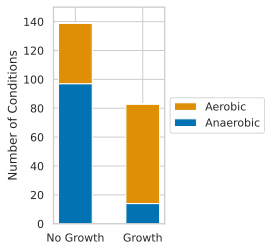

In [35]:
aerobic_carbon_no_growth = 0
aerobic_carbon_growth = 0
anaerobic_carbon_no_growth = 0
anaerobic_carbon_growth = 0
nitrogen_no_growth = 0
nitrogen_growth = 0
phosphorus_no_growth = 0
phosphorus_growth = 0
sulfur_no_growth = 0
sulfur_growth = 0

for key in well_id_media_dict.keys():
    # Carbon
    if key.startswith('PM1') or key.startswith('PM2'):
        if key[-2:] == '_1':
            if gng_dict_long[key] == 0:
                aerobic_carbon_no_growth += 1
            elif gng_dict_long[key] == 1:
                aerobic_carbon_growth += 1
        if key[-2:] == '_0':
            if gng_dict_long[key] == 0:
                anaerobic_carbon_no_growth += 1
            elif gng_dict_long[key] == 1:
                anaerobic_carbon_growth += 1
    # Alt nitrogen sources
    elif key.startswith('PM3'):
        if gng_dict_long[key] == 0:
            nitrogen_no_growth += 1
        elif gng_dict_long[key] == 1:
            nitrogen_growth += 1
    # Alt phosphorus sources
    elif key.startswith('PM4A') or key.startswith('PM4B') or key.startswith('PM4C') or key.startswith('PM4D') or key.startswith('PM4E'):
        if gng_dict_long[key] == 0:
            phosphorus_no_growth += 1
        elif gng_dict_long[key] == 1:
            phosphorus_growth += 1
    # Alt Sulfur sources
    elif key.startswith('PM4F') or key.startswith('PM4G') or key.startswith('PM4H'):
        if gng_dict_long[key] == 0:
            sulfur_no_growth += 1
        elif gng_dict_long[key] == 1:
            sulfur_growth += 1
    else:
        print('ERROR')
        
ind = np.arange(2)
width = 0.5

anc = [anaerobic_carbon_no_growth, anaerobic_carbon_growth]

ac = [aerobic_carbon_no_growth, aerobic_carbon_growth]

n_ng = anaerobic_carbon_no_growth + aerobic_carbon_no_growth
n_g = anaerobic_carbon_growth + aerobic_carbon_growth
n_bottom = [n_ng, n_g]
n = [nitrogen_no_growth, nitrogen_growth]

p_ng = n_ng + nitrogen_no_growth
p_g = n_g + nitrogen_growth
p_bottom = [p_ng, p_g]
p = [phosphorus_no_growth, phosphorus_growth]

s_ng = p_ng + phosphorus_no_growth
s_g = p_g + phosphorus_growth
s_bottom = [s_ng, s_g]
s = [sulfur_no_growth, sulfur_growth]

# %config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (2, 4))

p1 = plt.bar(ind, anc, width)
p2 = plt.bar(ind, ac, width, bottom=anc)
p3 = plt.bar(ind, n, width, bottom=n_bottom)
p4 = plt.bar(ind, p, width, bottom=p_bottom)
p5 = plt.bar(ind, s, width, bottom=s_bottom)

plt.ylabel('Number of Conditions')
plt.xticks(ind, ('No Growth','Growth'))
plt.ylim(0, 150)

plt.legend((p2[0], p1[0]),
           ('Aerobic', 'Anaerobic'),
            loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

In [36]:
# Adjust reaction IDs to match IDs in Universal Model
list(reaction_scores['reaction'])[0].replace('R_','')
# Make dictionary from reaction scores df
rxn_scores_dict = {}
for index, row in reaction_scores.iterrows():
    rxn_scores_dict[row['reaction'].replace('R_','')] = [row['bitscore']]
    
# Remove reaction scores for reactions that aren't in the universal model
missing_rxns_w_scores = []
rxn_scores_dict_alt = dict()
for key, val in rxn_scores_dict.items():
    try:
        universal.reactions.get_by_id(key)
        rxn_scores_dict_alt[key] = val
    except:
        missing_rxns_w_scores.append(key)
len(missing_rxns_w_scores)

376

In [37]:
count_rxns = 0
for rxn in universal.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        if rxn.lower_bound > 0.0 or rxn.upper_bound > 0.0:
            count_rxns += 1
print(count_rxns)

3881


In [38]:
# Check no growth in condition without carbon source...
base_media = ['co2_e','fe3_e','h_e','mn2_e','fe2_e','zn2_e','mg2_e','ca2_e','ni2_e','cu2_e',
              'sel_e','cobalt2_e','h2o_e','mobd_e','k_e','na1_e','cl_e','tungs_e','slnt_e','o2_e']

rxn_weights_pfba = convert_to_weight_space(universal, rxn_scores_dict_alt, pfba=True)
pfba_expr = write_dgFBA_expr(universal, rxn_weights_pfba)

set_dgFBA_media(universal, base_media)
solution = dgFBA(universal, pfba_expr, 'Biomass') # BIOMASS_Ec_iML1515_core_75p37M

try:
    active_rxns = set([rxn.id for rxn in universal.reactions if abs(solution.fluxes[rxn.id]) > 1e-6])
    print(len(active_rxns))
    print(solution.fluxes['Biomass'])
except:
    print(solution)

0
0.0


In [39]:
rxn_weights = convert_to_weight_space(universal, rxn_scores_dict_alt, compression=0.0)

In [40]:
# Make E.coli CANYUN using Universal_ML1515
t0 = time.time()
rxn_weights = convert_to_weight_space(universal, rxn_scores_dict_alt, compression=0.0)
dgfba_expr = write_dgFBA_expr(universal, rxn_weights)
CANYUN_output = make_canyun2(universal, dgfba_expr, well_id_media_dict, 'Biomass')
CANYUN_usage_dict = make_usage_dict2(universal, CANYUN_output[4], gng_dict_long)
t1 = time.time()

total = t1-t0
print(str(total)+' Secounds')

print(len(CANYUN_output[0]))
print(len(CANYUN_output[1]))
print(len(CANYUN_output[2]))
print(len(CANYUN_output[3]))

feasible_media_conditions = dict()
for well_key in CANYUN_output[0]:
    feasible_media_conditions[well_key] = well_id_media_dict[well_key]
print(len(feasible_media_conditions))

131.64380741119385 Secounds
169
53
0
0
169


In [41]:
# len(CANYUN_usage_dict)

In [42]:
# Test if the used reactions make an accurate model

# Remove all reactions that don't have usage values
test_usage_model = deepcopy(universal)

rxns_w_genes = []
for key, value in rxn_scores_dict_alt.items():
    if value[0] > 500:
        rxns_w_genes.append(key)

toRemove = []
for rxn in test_usage_model.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']: # and rxn.id not in rxns_w_genes: #  
        try:
            vals = CANYUN_usage_dict[rxn.id]
            if vals[0] == 0.0:
                rxn.upper_bound = 0.0
            if vals[1] == 0.0:
                rxn.lower_bound = 0.0
        except:
#             rxn.upper_bound = 0.0
#             rxn.lower_bound = 0.0
            toRemove.append(rxn)
        
test_usage_model.remove_reactions(toRemove)

t0 = time.time()
test_pfba_weights = convert_to_weight_space(test_usage_model, rxn_scores_dict_alt, pfba=True)
test_pfba_expr = write_dgFBA_expr(test_usage_model, test_pfba_weights)
test_output = make_canyun2(test_usage_model, test_pfba_expr, well_id_media_dict, 'Biomass')
t1 = time.time()

total = t1-t0
print(str(total)+' Secounds')

calc_acc(test_output)

16.247162342071533 Secounds
Accuracy: 0.7342342342342343
True Pos 74
False Pos 50
True Neg 89
False Neg 9
-------------------


0.7342342342342343

# Reaction Conditional Essentiality

In [43]:
fp_f_ess_dict = dict()

print("Start time:-", datetime.datetime.now())

for key in test_output[0]:
    if gng_dict_long[key] == 0:
        print('Started:', key, 'at', datetime.datetime.now())
        fp_essential_rxns_f = find_f_essential_rxns(test_usage_model, key, well_id_media_dict)
        fp_f_ess_dict[key] = fp_essential_rxns_f
        
print("Finish time:-", datetime.datetime.now())

Start time:- 2021-07-23 16:32:24.046192
Started: PM1A2_0 at 2021-07-23 16:32:24.046468
PM1A2_0 11.423879174177472
Started: PM1A3_0 at 2021-07-23 16:32:26.315293
PM1A3_0 15.188982744562917
Started: PM1A4_0 at 2021-07-23 16:32:28.848191
PM1A4_0 13.472966277606163
Started: PM1A6_0 at 2021-07-23 16:32:31.770360
PM1A6_0 11.827176140713139
Started: PM1A7_0 at 2021-07-23 16:32:34.007442
PM1A7_0 9.221554415180114
Started: PM1A9_0 at 2021-07-23 16:32:36.560134
PM1A9_0 3.8331946597863933
Started: PM1A10_0 at 2021-07-23 16:32:39.210906
PM1A10_0 12.21352822853873
Started: PM1A11_0 at 2021-07-23 16:32:41.267471
PM1A11_0 13.85329213443658
Started: PM1B4_0 at 2021-07-23 16:32:43.699763
PM1B4_0 4.629252592008401
Started: PM1B5_0 at 2021-07-23 16:32:46.039356
PM1B5_0 19.09607449293867
Started: PM1B6_0 at 2021-07-23 16:32:48.353417
PM1B6_0 17.349084671400945
Started: PM1B7_0 at 2021-07-23 16:32:51.072601
PM1B7_0 18.222534457503667
Started: PM1B8_0 at 2021-07-23 16:32:53.507795
PM1B8_0 11.423879174177472

In [44]:
fp_r_ess_dict = dict()

print("Start time:-", datetime.datetime.now())

for key in test_output[0]:
    if gng_dict_long[key] == 0:
        print('Started:', key, 'at', datetime.datetime.now())
        fp_essential_rxns_r = find_r_essential_rxns(test_usage_model, key, well_id_media_dict)
        fp_r_ess_dict[key] = fp_essential_rxns_r
        
print("Finish time:-", datetime.datetime.now())

Start time:- 2021-07-23 16:37:05.344783
Started: PM1A2_0 at 2021-07-23 16:37:05.345365
PM1A2_0 11.423879174177472
Started: PM1A3_0 at 2021-07-23 16:37:07.342561
PM1A3_0 15.188982744562917
Started: PM1A4_0 at 2021-07-23 16:37:09.357627
PM1A4_0 13.472966277606163
Started: PM1A6_0 at 2021-07-23 16:37:12.037592
PM1A6_0 11.827176140713139
Started: PM1A7_0 at 2021-07-23 16:37:13.997658
PM1A7_0 9.221554415180114
Started: PM1A9_0 at 2021-07-23 16:37:16.172900
PM1A9_0 3.8331946597863933
Started: PM1A10_0 at 2021-07-23 16:37:18.349854
PM1A10_0 12.21352822853873
Started: PM1A11_0 at 2021-07-23 16:37:21.074768
PM1A11_0 13.85329213443658
Started: PM1B4_0 at 2021-07-23 16:37:23.490487
PM1B4_0 4.629252592008401
Started: PM1B5_0 at 2021-07-23 16:37:25.683303
PM1B5_0 19.09607449293867
Started: PM1B6_0 at 2021-07-23 16:37:27.937775
PM1B6_0 17.349084671400945
Started: PM1B7_0 at 2021-07-23 16:37:30.642776
PM1B7_0 18.222534457503667
Started: PM1B8_0 at 2021-07-23 16:37:33.042680
PM1B8_0 11.423879174177472

In [45]:
# tp_r_ess_dict = dict()
tp_f_ess_dict = dict()

for key in test_output[0]:
    if gng_dict_long[key] > 0: # PM1D12_1
        print('Started:', key, 'at', datetime.datetime.now())
        tp_essential_rxns_f  = find_f_essential_rxns(test_usage_model, key, well_id_media_dict)
        tp_f_ess_dict[key] = tp_essential_rxns_f
print("Finished: ", datetime.datetime.now())

Started: PM1A2_1 at 2021-07-23 16:39:30.048096
PM1A2_1 26.319966036717275
Started: PM1A3_1 at 2021-07-23 16:39:33.984819
PM1A3_1 27.797918071388324
Started: PM1A4_1 at 2021-07-23 16:39:37.390986
PM1A4_1 23.421680772000524
Started: PM1A5_1 at 2021-07-23 16:39:40.416062
PM1A5_1 18.378434010394827
Started: PM1A6_1 at 2021-07-23 16:39:43.633124
PM1A6_1 26.319966036717414
Started: PM1A7_1 at 2021-07-23 16:39:46.717060
PM1A7_1 18.55624749328293
Started: PM1A8_1 at 2021-07-23 16:39:50.517694
PM1A8_1 18.11662749009361
Started: PM1A9_1 at 2021-07-23 16:39:53.590130
PM1A9_1 17.39457286369474
Started: PM1A10_1 at 2021-07-23 16:39:56.522607
PM1A10_1 27.80902527315691
Started: PM1A11_1 at 2021-07-23 16:39:59.825396
PM1A11_1 26.31996603671648
Started: PM1B1_1 at 2021-07-23 16:40:02.971689
PM1B1_1 17.8769060960627
Started: PM1B1_0 at 2021-07-23 16:40:06.320957
PM1B1_0 8.830563595234258
Started: PM1B2_1 at 2021-07-23 16:40:09.162390
PM1B2_1 24.02063000015977
Started: PM1B2_0 at 2021-07-23 16:40:12.833

In [46]:
tp_r_ess_dict = dict()

for key in test_output[0]:
    if gng_dict_long[key] > 0: # and key != 'PM1C11_0':
        print('Started:', key, 'at', datetime.datetime.now())
        tp_essential_rxns_r = find_r_essential_rxns(test_usage_model, key, well_id_media_dict)
        tp_r_ess_dict[key] = tp_essential_rxns_r
print("Finished: ", datetime.datetime.now())

Started: PM1A2_1 at 2021-07-23 16:43:55.967941
PM1A2_1 26.319966036717275
Started: PM1A3_1 at 2021-07-23 16:43:58.835416
PM1A3_1 27.797918071388324
Started: PM1A4_1 at 2021-07-23 16:44:01.738169
PM1A4_1 23.421680772000524
Started: PM1A5_1 at 2021-07-23 16:44:04.614689
PM1A5_1 18.378434010394827
Started: PM1A6_1 at 2021-07-23 16:44:07.590198
PM1A6_1 26.319966036717414
Started: PM1A7_1 at 2021-07-23 16:44:11.468996
PM1A7_1 18.55624749328293
Started: PM1A8_1 at 2021-07-23 16:44:14.252085
PM1A8_1 18.11662749009361
Started: PM1A9_1 at 2021-07-23 16:44:16.935708
PM1A9_1 17.39457286369474
Started: PM1A10_1 at 2021-07-23 16:44:19.987706
PM1A10_1 27.80902527315691
Started: PM1A11_1 at 2021-07-23 16:44:22.737317
PM1A11_1 26.31996603671648
Started: PM1B1_1 at 2021-07-23 16:44:25.711106
PM1B1_1 17.8769060960627
Started: PM1B1_0 at 2021-07-23 16:44:28.828644
PM1B1_0 8.830563595234258
Started: PM1B2_1 at 2021-07-23 16:44:31.764050
PM1B2_1 24.02063000015977
Started: PM1B2_0 at 2021-07-23 16:44:34.756

In [47]:
# Reverse
fp_r_ess_set = set()
fp_r_ess_list = list()
for key, val in fp_r_ess_dict.items():
    fp_r_ess_set |= set(val)
    fp_r_ess_list = fp_r_ess_list + val

fp_r_ess_count = Counter(fp_r_ess_list)

tp_r_ess_set = set()
tp_r_ess_list = list()
for key, val in tp_r_ess_dict.items():
    tp_r_ess_set |= set(val)
    tp_r_ess_list = tp_r_ess_list + val

tp_r_ess_count = Counter(tp_r_ess_list)

colors_r = []
x_r = []
y_r =[]

for key, val in fp_r_ess_count.items():
    try:
        score_str = str(rxn_scores_dict_alt[key][0])
        score_temp = rxn_scores_dict_alt[key][0]
    except:
        score_str = 'nan'
        score_temp = 0.0
    try:
        if val > tp_r_ess_count[key] and val > 1:
#             colors_r.append(score_temp)
#             x_r.append(val)
            x_r.append(score_temp)
            y_r.append(val - tp_r_ess_count[key])
            print(key + '\tGE: '+ score_str + ':\tFP: ' + str(val) + ',\tTP: ' + str(tp_r_ess_count[key]))
    except:
#         colors_r.append(score_temp)
#         x_r.append(val)
        x_r.append(score_temp)
#         y_r.append(0)
        y_r.append(val)
        print(key + '\tGE: '+ score_str + ':\tFP: ' + str(val) + ',\tTP: 0')

NH4t	GE: 807.7:	FP: 7,	TP: 2
MALtex	GE: 765.0:	FP: 3,	TP: 0
ICDHyr	GE: 841.6:	FP: 2,	TP: 1


In [48]:
# Forward
fp_f_ess_set = set()
fp_f_ess_list = list()
for key, val in fp_f_ess_dict.items():
    fp_f_ess_set |= set(val)
    fp_f_ess_list = fp_f_ess_list + val

fp_f_ess_count = Counter(fp_f_ess_list)

tp_f_ess_set = set()
tp_f_ess_list = list()
for key, val in tp_f_ess_dict.items():
    tp_f_ess_set |= set(val)
    tp_f_ess_list = tp_f_ess_list + val

tp_f_ess_count = Counter(tp_f_ess_list)

x_f = []
y_f = []

for key, val in fp_f_ess_count.items():
    try:
        score_str = str(rxn_scores_dict_alt[key][0])
        score_temp = rxn_scores_dict_alt[key][0]
    except:
        score_str = 'nan'
        score_temp = 0.0
    try:
        if val > tp_f_ess_count[key] and val > 1: #  
            x_f.append(score_temp)
            y_f.append(val - tp_f_ess_count[key])
            print(key + '\tGE: '+ score_str + ':\tFP: ' + str(val) + ',\tTP: ' + str(tp_f_ess_count[key]))
    except:
        x_f.append(score_temp)
        y_f.append(val)
        print(key + '\tGE: '+ score_str +':\tFP: ' + str(val) + ',\tTP: 0')

PPC	GE: 1750.7:	FP: 43,	TP: 8
SUCCt2b	GE: 824.3:	FP: 50,	TP: 9
OPHHX3	GE: nan:	FP: 50,	TP: 9
FRD2	GE: 558.45:	FP: 50,	TP: 9
SUCCtex	GE: 765.0:	FP: 3,	TP: 0
MALt5	GE: 899.0:	FP: 6,	TP: 1
PPS	GE: 1567.7:	FP: 6,	TP: 1
SUCCt1pp	GE: nan:	FP: 3,	TP: 0
MALt2_2pp	GE: 785.0:	FP: 2,	TP: 1


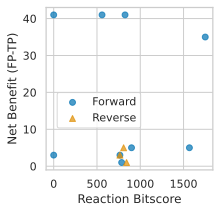

In [52]:
plt.figure(figsize = (3, 3))
plt.scatter(x_f, y_f, alpha=0.7)
plt.scatter(x_r, y_r, marker='^', alpha=0.7)
plt.legend(['Forward','Reverse'], frameon=True).set_bbox_to_anchor((.59, .51))
plt.xlabel('Reaction Bitscore')
plt.ylabel('Net Benefit (FP-TP)')
plt.show()

In [53]:
universal.reactions.get_by_id('OPHHX3')

<Reaction OPHHX3 at 0x7fd35ee881d0>

# CANYUN model

In [54]:
# Test if the used reactions make an accurate model

# Remove all reactions that don't have usage values
test_usage_model = deepcopy(universal)

toRemove = []
for rxn in test_usage_model.reactions:
        
    if rxn.id in ['OPHHX3']:
        rxn.upper_bound = 0.0
        
    
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']: 
        try:
            vals = CANYUN_usage_dict[rxn.id]
            if vals[0] == 0.0:
                rxn.upper_bound = 0.0
            if vals[1] == 0.0:
                rxn.lower_bound = 0.0
        except:
            toRemove.append(rxn)
        
test_usage_model.remove_reactions(toRemove)

t0 = time.time()
test_pfba_weights = convert_to_weight_space(test_usage_model, rxn_scores_dict_alt, pfba=True)
test_pfba_expr = write_dgFBA_expr(test_usage_model, test_pfba_weights)
test_output = make_canyun2(test_usage_model, test_pfba_expr, well_id_media_dict, 'Biomass')
t1 = time.time()

total = t1-t0
print(str(total)+' Secounds')

calc_acc(test_output)

13.962159395217896 Secounds
Accuracy: 0.918918918918919
True Pos 65
False Pos 0
True Neg 139
False Neg 18
-------------------


0.918918918918919

In [55]:
# Heatmap 'Venn diagram'
CANYUN_usage_dict_temp = make_usage_dict2(universal, CANYUN_output[4], gng_dict_long)
canyun_rxn_ids = set(CANYUN_usage_dict_temp.keys())

rxns_w_ge = []
uni_rxn_ids = []
for rxn in universal.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        uni_rxn_ids.append(rxn.id)
        try:
            if rxn_scores_dict_alt[rxn.id][0] > 500.0:
                rxns_w_ge.append(rxn.id)
        except:
            continue
rxns_w_ge = set(rxns_w_ge)
uni_rxn_ids = set(uni_rxn_ids)

print('Total rxns set', len(uni_rxn_ids))

print('Rxns w/ evidence', len(rxns_w_ge))

Total rxns set 4140
Rxns w/ evidence 2010


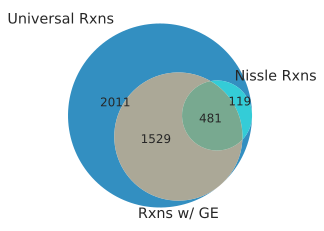

In [56]:
c = colors
venn3([uni_rxn_ids, canyun_rxn_ids, rxns_w_ge], set_colors=(c[0],c[2],c[3]), alpha=0.8,
      set_labels=('Universal Rxns', 'Nissle Rxns', 'Rxns w/ GE'))
plt.show()

In [57]:
ML1515_exs = cobra.io.load_json_model('iML1515.json')

In [58]:
count = 1
not_in_count = 0
all_rxn_scores = []
all_rxn_vals = []
unknown_rxn_vals = []
for rxn in test_usage_model.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        try:
            vals = CANYUN_usage_dict[rxn.id]
        except:
            vals = [0.0,0.0]
        if vals[0] >= 0.0001 or vals[1] >= 0.0001:
            try:
                gpr = ML1515_exs.reactions.get_by_id(rxn.id).gene_reaction_rule
            except:
                gpr = 'Not in iML1515'
            try:
                rxn_score_temp = rxn_scores_dict_alt[rxn.id][0]
                if rxn_score_temp < 500:
                    print(count, rxn.id, vals, rxn_score_temp, gpr)
                    if rxn_score_temp != 1:
                        all_rxn_scores.append(rxn_score_temp)
                        all_rxn_vals.append(max(vals))
                        count += 1
            except:
                rxn_score_temp = 'unknown'
                print(count, rxn.id, vals, rxn_score_temp, gpr)
                unknown_rxn_vals.append(max(vals))
                count += 1

1 2HXMPt6 [0.0, 0.013513513513513514] unknown Not in iML1515
2 ACGK [1.0, 0.0] 499.2 b3959
3 ACt2rpp [0.0, 0.9594594594594594] unknown b0010
4 ADK1 [1.0, 0.0] 456.4 b0474
5 ADNK1 [0.013513513513513514, 0.0] 456.4 b0474
6 ADSK [1.0, 0.0] 403.3 b2750
7 AICART2 [0.12162162162162163, 0.0] unknown Not in iML1515
8 AIRC3 [0.0, 0.972972972972973] 328.6 b0523
9 AKGMAL [0.0, 0.013513513513513514] unknown Not in iML1515
10 ALLPI [0.02702702702702703, 0.0] 296.2 b4090
11 ALLULPE [0.02702702702702703, 0.0] 467.2 b4085
12 AMANAPEr [0.04054054054054054, 0.0] 443.0 b3223
13 ASP1DC [1.0, 0.0] 253.1 b0131
14 ATPS4rpp [0.8918918918918919, 0.0] 492.8125 (b3739 and (b3731 and b3733 and b3735 and b3734 and b3732) and (b3738 and b3736 and b3737)) or ((b3731 and b3733 and b3735 and b3734 and b3732) and (b3738 and b3736 and b3737))
15 CBFC2pp [0.05405405405405406, 0.0] unknown Not in iML1515
16 CHRPL [1.0, 0.0] 330.9 b4039 or b1096
17 CMCBTFL [1.0, 0.0] unknown Not in iML1515
18 CMCBTFU [1.0, 0.0] unknown Not

Text(0, 0.5, 'Reaction Certainty Value')

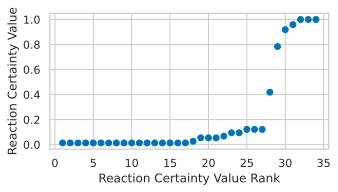

In [59]:
plt.figure(figsize = (5, 2.5))

unknown_rxn_vals.sort()
plt.plot(range(1, len(unknown_rxn_vals)+1), unknown_rxn_vals, marker='o', linestyle='')
plt.xlabel('Reaction Certainty Value Rank')
plt.ylabel('Reaction Certainty Value')

80


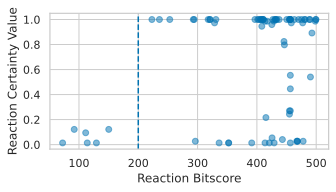

In [60]:
plt.figure(figsize = (5, 2.5))

plt.plot(all_rxn_scores, all_rxn_vals, marker='o', linestyle='', alpha = 0.5)
plt.axvline(200, 0, 1, linestyle='--')
plt.xlabel('Reaction Bitscore')
plt.ylabel('Reaction Certainty Value')

print(len(all_rxn_scores))